In [1]:
!pip3 install openpyxl seaborn scikit-learn statsmodels
import pandas as pd
import matplotlib.pyplot as plt

# Wczytanie danych z pliku
df = pd.read_csv('../cw3/daneZ3_zad2.csv', sep=';', decimal=',')

# Podstawowe statystyki opisowe
print(df.describe())

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
                Y           X
count  200.000000  200.000000
mean    -0.057649    0.509500
std      0.348769    0.293102
min     -0.828374    0.006283
25%     -0.327804    0.244374
50%     -0.102237    0.548429
75%      0.184383    0.773101
max      0.889414    0.998870


# Zadanie 2
### 2.1
Za pomocą Metody Najmniejszych Kwadratów dokonać estymacji parametrów modelu postaci 𝑌 = 𝑎 + 𝑏𝑋. Utworzyć wykres reszt z tego modelu.

Estymacja parametrów: a = -0.06291081798487833, b = 0.01032761411089966


/var/folders/zr/wgdvlh6d0h1__zchdn3xjf7c0000gn/T/ipykernel_48970/2036762372.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a = model.params[0]  # Wyraz wolny
/var/folders/zr/wgdvlh6d0h1__zchdn3xjf7c0000gn/T/ipykernel_48970/2036762372.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b = model.params[1]  # Nachylenie


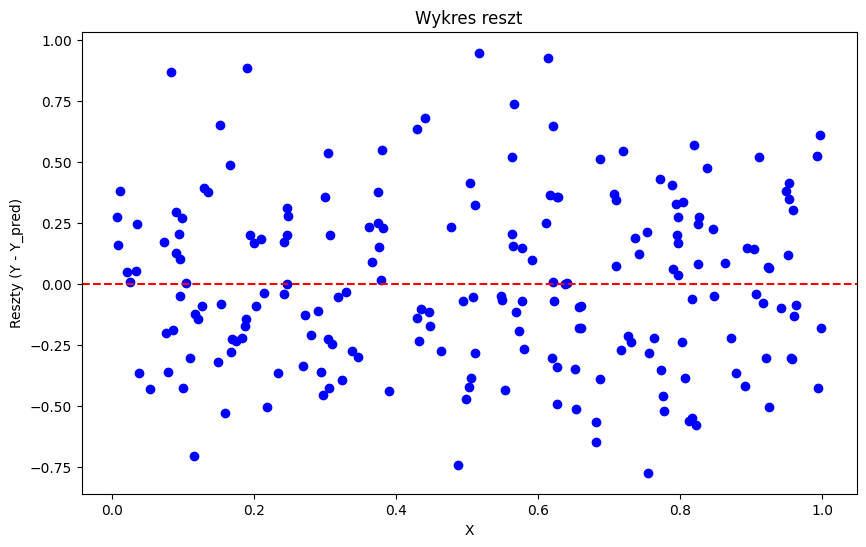

Estymacja parametrów: a = -0.0629108179848783, b = 0.010327614110899686


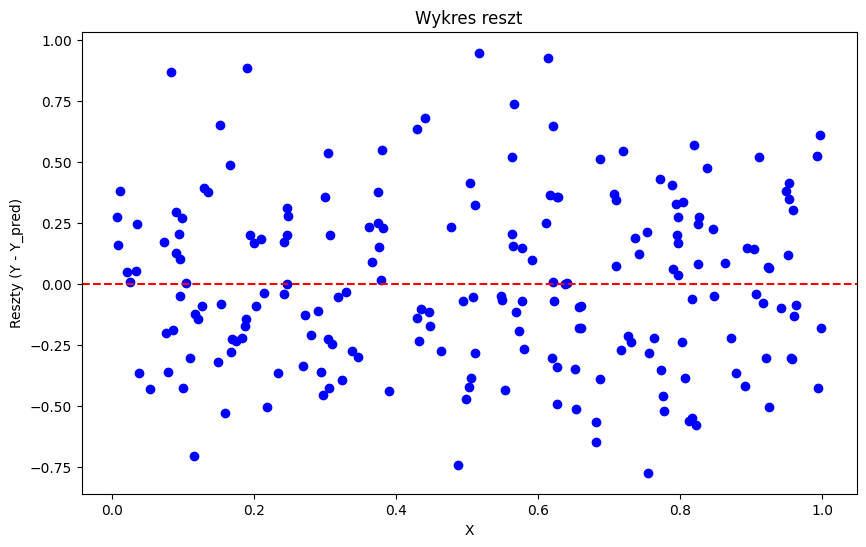

In [4]:
import numpy as np
from statsmodels.api import OLS, add_constant

# Dodanie wyrazu wolnego (stała) do X
X = add_constant(df['X'])  # Dodajemy 1 w każdej próbce, co odpowiada wyrazowi wolnemu w równaniu

# Model regresji
model = OLS(df['Y'], X).fit()  # Przygotowanie modelu

# Estymowane parametry (a i b)
a = model.params[0]  # Wyraz wolny
b = model.params[1]  # Nachylenie
print(f"Estymacja parametrów: a = {a}, b = {b}")

# Przewidywane wartości Y
df['Y_pred'] = model.predict(X)

# Obliczenie reszt
df['residuals'] = df['Y'] - df['Y_pred']

# Wykres reszt
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['residuals'], color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Wykres reszt')
plt.xlabel('X')
plt.ylabel('Reszty (Y - Y_pred)')
plt.show()

# Teraz samemu ręcznie obliczmy model za pomocą MNK
# Obliczanie średnich X i Y
X_mean = df['X'].mean()  # Średnia z kolumny X
Y_mean = df['Y'].mean()  # Średnia z kolumny Y

# Obliczanie parametru b (nachylenie)
b_numerator = np.sum((df['X'] - X_mean) * (df['Y'] - Y_mean))  # Suma (X_i - X_mean)(Y_i - Y_mean)
b_denominator = np.sum((df['X'] - X_mean) ** 2)  # Suma (X_i - X_mean)^2
b = b_numerator / b_denominator

# Obliczanie parametru a (wyraz wolny)
a = Y_mean - b * X_mean

print(f"Estymacja parametrów: a = {a}, b = {b}")

# Obliczenie przewidywanych wartości Y
df['Y_pred'] = a + b * df['X']

# Obliczenie reszt
df['residuals'] = df['Y'] - df['Y_pred']

# Wykres reszt
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['residuals'], color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Wykres reszt')
plt.xlabel('X')
plt.ylabel('Reszty (Y - Y_pred)')
plt.show()

### 2.2
Sporządzić korelogram dla reszt z modelu. Zinterpretować go (opisać funkcje ACF i PACF)

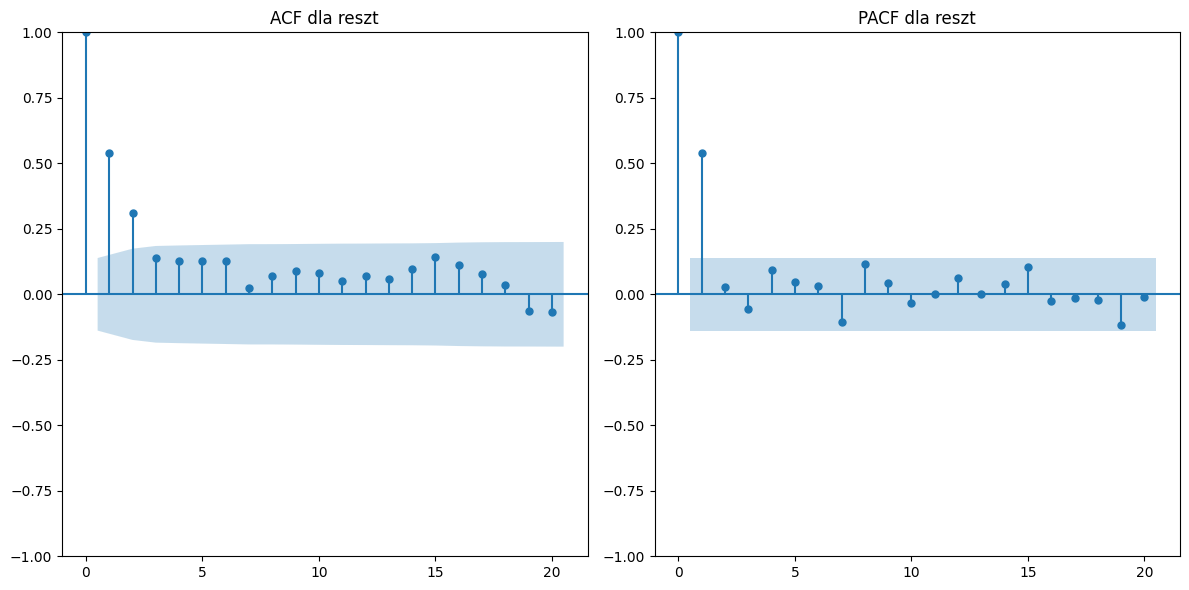

In [5]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Wykres ACF i PACF dla reszt
plt.figure(figsize=(12, 6))

# ACF
plt.subplot(1, 2, 1)
plot_acf(df['residuals'], lags=20, ax=plt.gca(), title='ACF dla reszt')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(df['residuals'], lags=20, ax=plt.gca(), title='PACF dla reszt')

plt.tight_layout()
plt.show()

W przypadku obu wykresów widzimy, że nie wszystkie dane są zbliżone do 0 i niektórę odstają, szczególnie początkowe 2-3.

ACF:
Początkowe opóźnienia w ACF mogą wskazywać na obecność autokorelacji w danych.
Oznacza to, że wartości reszt w obecnym momencie są powiązane z wartościami z poprzednich momentów.
Jeśli ACF pokazuje wyraźną korelację w początkowych opóźnieniach (np. opóźnienie 1, 2, 3),
może to sugerować, że model regresji nie uwzględnił w pełni jakiejś struktury czasowej, która jest obecna w danych.

PACF:
Jeśli PACF pokazuje, że początkowe punkty są znaczące, to może to oznaczać,
że istnieje zależność pomiędzy zmiennymi w różnych opóźnieniach, którą należy uwzględnićW szczególności,
jeśli PACF ma wyraźny "cięcie" po pierwszych kilku opóźnieniach, to może sugerować,
że zależność w danych jest ograniczona do tych początkowych opóźnień i że inne opóźnienia już nie mają wpływu.

### 2.3
Wykorzystując testy Durbina-Watsona, Breuscha-Godfreya oraz Ljung-Boxa sprawdzić występowanie autokorelacji składnika losowego.

In [6]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, pacf, q_stat

residuals = model.resid  # Reszty z modelu

# 2. Test Durbin-Watson
dw_statistic = durbin_watson(residuals)
print(f"Test Durbin-Watson: {dw_statistic}")

# 3. Test Breuscha-Godfreya (sprawdzenie autokorelacji w wyższych rzędach)
bg_results = acorr_breusch_godfrey(model, nlags=4)  # Testujemy dla 4 opóźnień

# Wyodrębnienie wyników
bg_test_stat = bg_results[0]  # Statystyka testowa
bg_p_value = bg_results[1]  # p-value

print(f"Test Breuscha-Godfreya: Statystyka = {bg_test_stat}, p-value = {bg_p_value}")

# 4. Test Ljung-Boxa (sprawdzenie autokorelacji w resztach)
ljung_box_stat, ljung_box_p_value = q_stat(acf(residuals, nlags=10)[1:], len(residuals))  # Testujemy dla pierwszych 10 opóźnień
print(f"Test Ljung-Boxa: Statystyka = {ljung_box_stat[-1]}, p-value = {ljung_box_p_value[-1]}")

Test Durbin-Watson: 0.9171189355125734
Test Breuscha-Godfreya: Statystyka = 61.170251833837106, p-value = 1.6463842339186827e-12
Test Ljung-Boxa: Statystyka = 96.70520328155368, p-value = 2.4823264273301207e-16


**Test Durbin-Watson (DW)**
Ponieważ wartość statystyki Durbin-Watsona jest znacznie mniejsza niż 2 (w tym przypadku bliska 1), wskazuje to na pozytywną autokorelację w resztach. Oznacza to, że reszty z modelu są skorelowane w sposób pozytywny, tzn. jeśli jedna reszta jest dodatnia, to następna reszta również ma tendencję do bycia dodatnia.

**Test Breuscha-Godfreya (BG)**
p-value jest bardzo małe (mniejsze niż 0.05), co oznacza, że odrzucamy hipotezę zerową (brak autokorelacji). To sugeruje, że w resztach występuje istotna autokorelacja, nawet w wyższych rzędach. Można stwierdzić, że model nie jest w pełni odpowiedni, ponieważ reszty są zależne od siebie.

**Test Ljung-Boxa**
p-value również jest bardzo małe (mniejsze niż 0.05), co wskazuje na istotną autokorelację w resztach. Wskazuje to, że reszty nie są niezależne, co może sugerować, że model nie uwzględnia wszystkich istotnych zależności w danych.


### 2.4
Zastosować procedurę Cochrane'a -Orcutta.

In [7]:
import statsmodels.api as sm

# Reszty z pierwotnego modelu
residuals = model.resid

# Estymacja rho (współczynnika autokorelacji)
# Bierzemy korelację reszt przesuniętych o 1
rho = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
print(f"Szacowane rho: {rho}")

# Przekształcenie zmiennych Y i X
Y_transformed = df['Y'].iloc[1:] - rho * df['Y'].iloc[:-1].values
X_transformed = df['X'].iloc[1:] - rho * df['X'].iloc[:-1].values

# Nowy model na przekształconych danych
X_transformed = sm.add_constant(X_transformed)  # Dodaj stałą
model_corrected = sm.OLS(Y_transformed, X_transformed).fit()

# Wyświetlenie wyników
print(model_corrected.summary())

Szacowane rho: 0.5400737709141391
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.212
Date:                Sun, 27 Apr 2025   Prob (F-statistic):              0.139
Time:                        12:29:49   Log-Likelihood:                -36.649
No. Observations:                 199   AIC:                             77.30
Df Residuals:                     197   BIC:                             83.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0